In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale

from ulca.ulca import ULCA
from ulca_ui.plot import Plot

In [2]:
import pyreadstat # please install via pip (pip3 install pyreadstat)
from ppic_meta import metainfo
df, meta = pyreadstat.read_sav("./data/ppic/2018.10.24.release.sav")

In [3]:
df

,id,version,county,q1,q2,q3,q4,q4a,q5,q5a,...,d13a,d14,d15,d16,lgdr,d1a,gender,language,likevote,weight
0,4.0,1.0,46.0,1.0,1.0,8.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,2.0,6.0,2.0,0.0,1.0,0.566456
1,5.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,2.0,NaN,2.0,6.0,2.0,0.0,1.0,0.509652
2,6.0,1.0,33.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,NaN,NaN,NaN,2.0,6.0,2.0,0.0,1.0,1.330116
3,9.0,1.0,15.0,2.0,2.0,1.0,1.0,2.0,NaN,2.0,...,NaN,NaN,NaN,NaN,2.0,5.0,2.0,0.0,0.0,1.570243
4,10.0,1.0,16.0,2.0,2.0,1.0,1.0,2.0,NaN,1.0,...,NaN,NaN,NaN,NaN,2.0,6.0,2.0,0.0,0.0,0.276546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,300235.0,2.0,43.0,8.0,1.0,1.0,2.0,6.0,NaN,NaN,...,NaN,2.0,NaN,1.0,2.0,2.0,2.0,0.0,0.0,0.910798
1700,300236.0,2.0,10.0,8.0,1.0,1.0,1.0,1.0,2.0,NaN,...,NaN,2.0,NaN,1.0,2.0,5.0,2.0,0.0,1.0,0.704589
1701,300237.0,2.0,19.0,1.0,2.0,2.0,1.0,1.0,2.0,NaN,...,NaN,2.0,NaN,1.0,2.0,3.0,2.0,0.0,1.0,1.833751
1702,300240.0,2.0,10.0,2.0,2.0,1.0,1.0,1.0,1.0,NaN,...,NaN,2.0,NaN,1.0,2.0,2.0,1.0,0.0,1.0,0.896070


In [4]:
# covert code to binary, categorical, numeric numbers
for col_key in df:
    df[col_key] = np.vectorize(metainfo[col_key]['code_num'])(df[col_key])

In [5]:
# remove attributes that we are not interested in
for col_key in df:
    if metainfo[col_key]['use'] == 0:
        del df[col_key]

In [6]:
# we only want to compare democrat vs republican supporters
# 1: Democrat, 2: Republican
df.drop(np.where(df['q4a'] > 2)[0], axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [7]:
# combine planned- and used-vote method
df['q37a'][df['q37a'] == 999] = df['q37b'][df['q37a'] == 999]
df.drop(['q37b'], axis=1, inplace=True)

In [8]:
col_na_ratios = np.array([np.sum(df[col_key] == 999) / df.shape[0] for col_key in df])

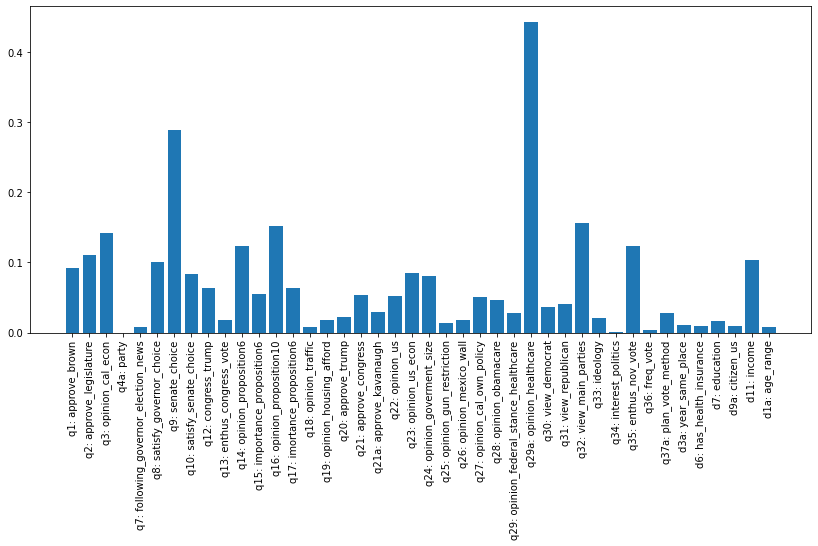

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(list(range(len(col_na_ratios))), col_na_ratios)
ax = plt.gca()
ax.set_xticks(list(range(len(col_na_ratios))))
ax.set_xticklabels([col_key + ': ' + metainfo[col_key]['short'] for col_key in df.columns], rotation=90)

plt.show()

In [10]:
# remove attributes that have many nan values
df.drop(df.columns[np.where(col_na_ratios > 0.1)[0]], axis=1, inplace=True)

In [11]:
# also drop other non-important attributes to reduce # of nan
# (e.g., there is a similar quesiton or related to the dropped cols)
# 'q10: satisfy_senate_choice',
# 'q12: congress_trump',
# 'q15: importance_proposition6',
# 'q17: imortance_proposition10',
df.drop(['q10', 'q12', 'q15', 'q17'], axis=1, inplace=True)

In [12]:
row_na_ratios = np.array([np.sum(row == 999) / df.shape[1] for index, row in df.iterrows()])

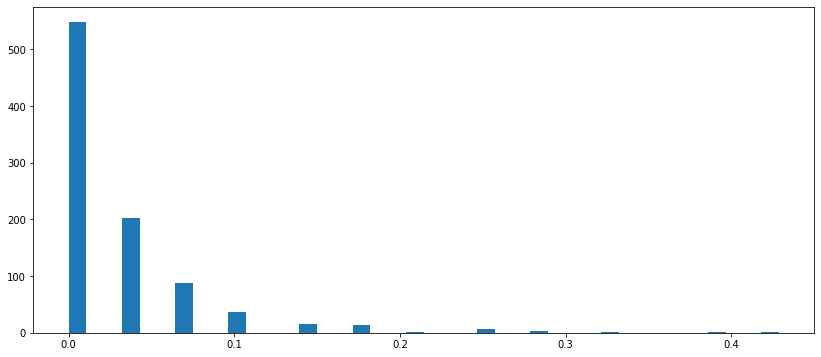

In [13]:
plt.figure(figsize=(14, 6))
plt.hist(row_na_ratios, bins=40)
plt.show()

In [14]:
# drop subjects who have NA in their answers
df = df.iloc[row_na_ratios <= 0.0, :]
df.reset_index(inplace=True, drop=True)

In [15]:
# use q4a as label
y = np.array(df['q4a'])
y[y == 1] = 0 # democrat
y[y == 2] = 1 # republican
y_to_name = {0: 'Dem', 1: 'Rep'}

df.drop(['q4a'], axis=1, inplace=True)
X = np.array(df)

feat_names = [] 
name_to_q = {}
for col_key in df.columns:
    name = col_key
    feat_names.append(name)
    name_to_q[name] = col_key
feat_names = np.array(feat_names)

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
# apply scaling
X = scale(X)

In [17]:
X.shape

(548, 27)

In [18]:
# prepare ULCA for comparative analysis
ulca = ULCA(n_components=2)

In [19]:
# cPCA to find hidden subgroups in Dem
w_tg = {0: 1, 1: 0}
w_bg = {0: 0, 1: 1}
w_bw = {0: 0, 1: 0}
alpha = 20 # 5.5

ulca = ulca.fit(X, y=y, w_tg=w_tg, w_bg=w_bg, w_bw=w_bw, alpha=alpha)

Plot().plot_emb(dr=ulca, X=X, y=y, w_tg=w_tg, w_bg=w_bg, w_bw=w_bw, alpha=alpha,
                feat_names=feat_names, y_to_name={0: 'Dem', 1: 'Rep'},
                w_area={'move': 0.3, 'scale': 0.7},
                w_dist={'move': 0.7, 'scale': 0.3}, weight_opt_max_iter=100)

Screenshot of the visualized result in UI
![title](plot_image/ppic1.png)

In [20]:
# separate dem in to dem(+) and dem(-)
dem_pos = (y == 0) & (df[name_to_q['q30']] == 1)
dem_neg = (y == 0) & (df[name_to_q['q30']] == 0)

y2 = np.zeros(len(y))
y2[dem_pos] = 0
y2[dem_neg] = 2
y2[y == 1] = 1

y2_to_name = {0: 'Dem (pos)', 1: 'Rep', 2: 'Dem (neg)'}

In [21]:
X2 = X[:, (feat_names != 'q30')]
feat_names = feat_names[(feat_names != 'q30')]

In [22]:
# cPCA to find what is inside of Dem (neg)

w_tg = {0: 0, 1: 0, 2: 1}
w_bg = {0: 1, 1: 1, 2: 0}
w_bw = {0: 0, 1: 0, 2: 0}
alpha = None

ulca = ulca.fit(X2, y=y2, w_tg=w_tg, w_bg=w_bg, w_bw=w_bw, alpha=alpha)

Plot().plot_emb(dr=ulca, X=X2, y=y2, w_tg=w_tg, w_bg=w_bg, w_bw=w_bw, alpha=alpha,
                feat_names=feat_names, y_to_name=y2_to_name,
                w_area={'move': 0.3, 'scale': 0.7},
                w_dist={'move': 0.7, 'scale': 0.3}, weight_opt_max_iter=100)

Screenshot of the visualized result in UI
![title](plot_image/ppic2.png)

In [23]:
X3 = np.zeros(X2.shape)
y3 = np.zeros(y2.shape)
n0 = np.sum(y2 == 0)
n1 = np.sum(y2 == 1)
n2 = np.sum(y2 == 2)

X3[:n0, :] = X2[y2 == 0, :]
X3[n0:(n0 + n1), :] = X2[y2 == 1, :]
X3[(n0 + n1):(n0 + n1 + n2), :] = X2[y2 == 2, :]
y3[:n0] = 0
y3[n0:(n0 + n1)] = 1
y3[(n0 + n1):(n0 + n1 + n2)] = 2

In [24]:
# find separation #2 (These parameters are after interaction)
w_tg = {0: 0.038365900514515154, 1: 0.03189631955255691, 2: 0.6337167203034522}
w_bg = {0: 0.3389743652498261, 1: 0.34867744858465005, 2: 0.058115068138408006}
w_bw = {0: 0.24387188666965084, 1: 0.024342165313444287, 2: 0.9843778233029735}
alpha = 3.2938344688343313

ulca = ulca.fit(X3, y=y3, w_tg=w_tg, w_bg=w_bg, w_bw=w_bw, alpha=alpha)

Plot().plot_emb(dr=ulca, X=X3, y=y3, w_tg=w_tg, w_bg=w_bg, w_bw=w_bw, alpha=alpha,
                feat_names=feat_names, y_to_name=y2_to_name,
                w_area={'move': 0.3, 'scale': 0.7},
                w_dist={'move': 0.7, 'scale': 0.3}, weight_opt_max_iter=100)

Screenshot of the visualized result in UI
![title](plot_image/ppic3.png)